In [1]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.3MB 4.3MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.6MB 5.3MB/s 
     |████████████████████████████████| 215kB 37.3MB/s 
     |████████████████████████████████| 1.2MB 21.2MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 358kB 44.2MB/s 
     |████████████████████████████████| 645kB 34.8MB/s 
     |████████████████████████████████| 37.2MB 68kB/s 
     |████████████████████████████████| 686kB 39.8MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 


In [40]:
import os 
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

tf.get_logger().setLevel('ERROR')

In [31]:
file_path = '/content/drive/MyDrive/Mini Project/Sentiment Analysis Datasets/Sentiment140/training.1600000.processed.noemoticon.csv'
columns = ['polarity','id','date','query_string','twitter_user','tweet']

df_train_main = pd.read_csv(file_path,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')

In [32]:
df_train_main.shape

(1600000, 6)

In [33]:
df_train_main.head(10)

,polarity,id,date,query_string,twitter_user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [48]:
df_train_main.groupby(['polarity']).size()

polarity
0    800000
4    800000
dtype: int64

In [41]:
df_shuffled = shuffle(df_train_main)

In [42]:
df_train = df_train_main.sample(n = 50000)
df_val = df_train_main.sample(n = 10000)

In [46]:
df_train.groupby(['polarity']).size()

polarity
0    25034
4    24966
dtype: int64

In [44]:
df_val.groupby(['polarity']).size()

polarity
0    4987
4    5013
dtype: int64

In [7]:
file_path = '/content/drive/MyDrive/Mini Project/Sentiment Analysis Datasets/Sentiment140/testdata.manual.2009.06.14.csv'
columns = ['polarity','id','date','query_string','twitter_user','tweet']

df_test = pd.read_csv(file_path,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')

In [8]:
df_test.shape

(498, 6)

In [9]:
df_test.head(10)

,polarity,id,date,query_string,twitter_user,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
5,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...
6,0,9,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non lo...
7,4,10,Mon May 11 03:26:10 UTC 2009,jquery,dcostalis,Jquery is my new best friend.
8,4,11,Mon May 11 03:27:15 UTC 2009,twitter,PJ_King,Loves twitter
9,4,12,Mon May 11 03:29:20 UTC 2009,obama,mandanicole,how can you not love Obama? he makes jokes abo...


In [47]:
df_test.groupby(['polarity']).size()

polarity
0    177
2    139
4    182
dtype: int64

In [49]:
df_test.drop(df_test[df_test['polarity'] == 2].index, inplace = True)

In [50]:
df_test.groupby(['polarity']).size()

polarity
0    177
4    182
dtype: int64

In [51]:
X_train = df_train['tweet']
y_train = df_train['polarity']
X_val = df_val['tweet']
y_val = df_val['polarity']
X_test = df_test['tweet']
y_test = df_test['polarity']

In [11]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [12]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
bert_model = hub.KerasLayer(tfhub_handle_model)

In [14]:
#X_train_preprocessed = bert_preprocess_model(X_train)
#X_val_preprocessed = bert_preprocess_model(X_val)
#X_test_preprocessed = bert_preprocess_model(X_test)

In [52]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [53]:
classifier_model = build_classifier_model()

In [54]:
y_train_normalized = y_train.map(lambda x: x/4)
y_val_normalized = y_val.map(lambda x: x/4)
y_test_normalized = y_test.map(lambda x: x/4)

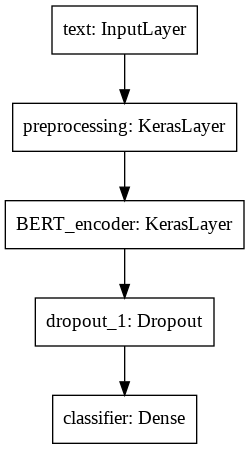

In [55]:
tf.keras.utils.plot_model(classifier_model)

In [56]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [57]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 3e-5),
                         loss=loss,
                         metrics=metrics)

In [58]:
history = classifier_model.fit(x = X_train,
                               y = y_train_normalized,
                               validation_split = 0.2,
                               epochs=5)

Epoch 1/5
1250/1250 [==============================] - 524s 414ms/step - loss: 0.4888 - binary_accuracy: 0.7512 - val_loss: 0.4261 - val_binary_accuracy: 0.7884
Epoch 2/5
1250/1250 [==============================] - 516s 413ms/step - loss: 0.3903 - binary_accuracy: 0.8202 - val_loss: 0.4360 - val_binary_accuracy: 0.7901
Epoch 3/5
1250/1250 [==============================] - 518s 415ms/step - loss: 0.3194 - binary_accuracy: 0.8601 - val_loss: 0.4416 - val_binary_accuracy: 0.8107
Epoch 4/5
1250/1250 [==============================] - 519s 415ms/step - loss: 0.2484 - binary_accuracy: 0.8953 - val_loss: 0.4888 - val_binary_accuracy: 0.8113
Epoch 5/5
1250/1250 [==============================] - 520s 416ms/step - loss: 0.1829 - binary_accuracy: 0.9262 - val_loss: 0.5638 - val_binary_accuracy: 0.8095


In [63]:
predictions = classifier_model.predict(['This is shit'])

In [64]:
print(tf.sigmoid(predictions))

tf.Tensor([[0.03493933]], shape=(1, 1), dtype=float32)


In [65]:
loss, accuracy = classifier_model.evaluate(X_test, y_test_normalized)

12/12 [==============================] - 2s 171ms/step - loss: 0.5901 - binary_accuracy: 0.8245


In [66]:
accuracy

0.8245125412940979